# Import Packages

In [85]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [139]:
TRAIN_SET = '../data/Hotel-A-train.csv'
VAL_SET = '../data/Hotel-A-validation.csv'

In [96]:
df = pd.read_csv(TRAIN_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout'])

In [140]:
df_val = pd.read_csv(VAL_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout'])

In [142]:
val_prof = ProfileReport(df_val)
val_prof.to_file(output_file='../output/pandas_profile_val.html')

Summarize dataset:   0%|          | 0/37 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

In [145]:
df.index.value_counts()

91130744    2
76641511    2
95504255    2
55371044    2
14692111    1
           ..
52434071    1
20278424    1
77227399    1
52382876    1
84871169    1
Name: Reservation-id, Length: 27495, dtype: int64

In [143]:
df.head()

,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
Reservation-id,,,,,,,,,,,,,,,,,,,,
39428300,1,40,1,1,1,1,1,2,2,0,1,1,1,1,1,1,1,1,10,218
77491756,1,49,1,2,2,2,1,3,3,0,1,1,1,2,1,1,1,2,0,185
73747291,1,42,2,1,1,2,1,3,3,0,1,1,1,1,1,1,1,2,0,119
67301739,2,25,3,3,3,3,2,4,3,0,1,1,1,2,2,1,1,1,5,144
77222321,1,62,1,4,4,2,3,1,1,0,1,1,1,1,3,2,1,1,10,242


In [5]:
df.columns

Index(['Gender', 'Age', 'Ethnicity', 'Educational_Level', 'Income',
       'Country_region', 'Hotel_Type', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Meal_Type',
       'Visted_Previously', 'Previous_Cancellations', 'Deposit_type',
       'Booking_channel', 'Required_Car_Parking', 'Reservation_Status',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate'],
      dtype='object')

In [6]:
df.dtypes

Gender                            object
Age                                int64
Ethnicity                         object
Educational_Level                 object
Income                            object
Country_region                    object
Hotel_Type                        object
Expected_checkin          datetime64[ns]
Expected_checkout         datetime64[ns]
Booking_date                      object
Adults                             int64
Children                           int64
Babies                             int64
Meal_Type                         object
Visted_Previously                 object
Previous_Cancellations            object
Deposit_type                      object
Booking_channel                   object
Required_Car_Parking              object
Reservation_Status                object
Use_Promotion                     object
Discount_Rate                      int64
Room_Rate                          int64
dtype: object

In [7]:
df.shape

(27499, 23)

In [8]:
df.index.nunique()

27495

<AxesSubplot:>

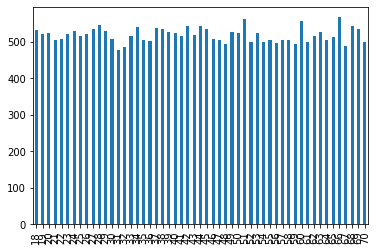

In [9]:
df.Age.value_counts().sort_index().plot.bar()

# Data Preprocessing

## Drop columns

In [97]:
df = df.drop(columns=['Expected_checkin', 'Expected_checkout', 'Booking_date'])

## Categorical encoding

In [102]:
categorical_features_indices = np.where((df.dtypes != np.float) & (df.dtypes != np.int64))[0]

In [103]:
cat_cols = df.columns[categorical_features_indices].to_list()

In [106]:
le = OrdinalEncoder(cols=cat_cols)

In [107]:
le.fit(df)

OrdinalEncoder(cols=['Gender', 'Ethnicity', 'Educational_Level', 'Income',
                     'Country_region', 'Hotel_Type', 'Meal_Type',
                     'Visted_Previously', 'Previous_Cancellations',
                     'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
                     'Reservation_Status', 'Use_Promotion'],
               drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 'Gender', 'data_...
                        {'col': 'Booking_channel', 'data_type': dtype('O'),
                         'mapping': Online    1
Agent     2
Direct    3
NaN      -2
dtype: int64},
                        {'col': 'Required_Car_Parking', 'data_type': dtype('O'),
                         'mapping': Yes    1
No     2
NaN   -2
dtype: int64},
                        {'col': 'Reservation_Status', 'data_type': dtype('O'),
                         'mapping': Check-In    1
Canceled    2
No-Show     3
NaN    

In [108]:
df = le.transform(df)

# Create Train/Test Dataset

In [109]:
X = df.drop(columns='Reservation_Status')
y = df['Reservation_Status']

In [110]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
categorical_features_indices

array([ 0,  2,  3,  4,  5,  6, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=int64)

In [112]:
df.dtypes

Gender                    int32
Age                       int64
Ethnicity                 int32
Educational_Level         int32
Income                    int32
Country_region            int32
Hotel_Type                int32
Adults                    int64
Children                  int64
Babies                    int64
Meal_Type                 int32
Visted_Previously         int32
Previous_Cancellations    int32
Deposit_type              int32
Booking_channel           int32
Required_Car_Parking      int32
Reservation_Status        int32
Use_Promotion             int32
Discount_Rate             int64
Room_Rate                 int64
dtype: object

# Model Training

In [132]:
model = XGBClassifier(n_estimators=500, n_jobs=-1, max_depth=3, class_weight='balanced')

In [133]:
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Model Evaluation

In [134]:
pred_y = model.predict(test_X)

In [135]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           1       0.78      0.98      0.87      4267
           2       0.28      0.04      0.07       810
           3       0.12      0.01      0.01       423

    accuracy                           0.77      5500
   macro avg       0.39      0.34      0.32      5500
weighted avg       0.65      0.77      0.68      5500



In [136]:
print(f1_score(test_y, pred_y, average='macro'))

0.31673925317860724


In [137]:
pred_y_train = model.predict(train_X)

In [138]:
print(f1_score(train_y, pred_y_train, average='macro'))

0.7571841903544686
